In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os

In [2]:
# to have TensorFlow start out using only a minimum amount of memory and then allocate more as needed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## Data Loading

In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)
SAVED_IN = os.path.abspath( DIR + "/models/V27/autoencoder/")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

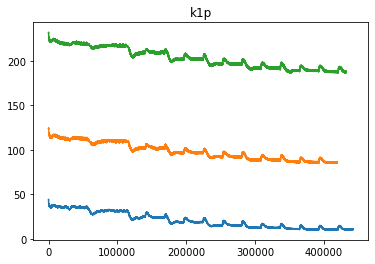

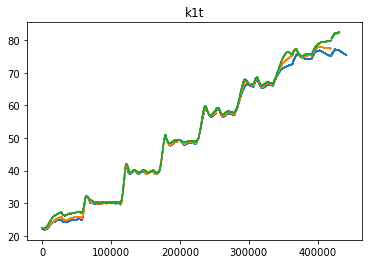

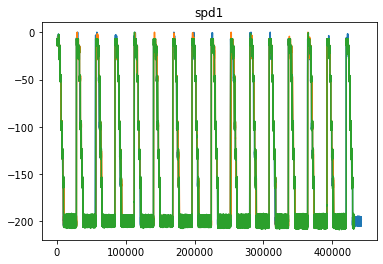

In [4]:
# load raw data and shifts
h5_p30 = h5py.File(file_list_LEM1[2], "r")
filename_p30 = file_list_LEM1[2].split(os.sep)[-1][:-3]
pklName_p30 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p30 + '.pkl'
shift_opts_freqs_all_p30 = pickle.load(open(pklName_p30, 'rb')) 

h5_p100 = h5py.File(file_list_LEM1[0], "r")
filename_p100 = file_list_LEM1[0].split(os.sep)[-1][:-3]
pklName_p100 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p100 + '.pkl'
shift_opts_freqs_all_p100 = pickle.load(open(pklName_p100, 'rb')) 

h5_p200 = h5py.File(file_list_LEM1[1], "r")
filename_p200 = file_list_LEM1[1].split(os.sep)[-1][:-3]
pklName_p200 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p200 + '.pkl'
shift_opts_freqs_all_p200 = pickle.load(open(pklName_p200, 'rb')) 


def plot3(h51,h52,h53,key):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(key)
    ax.plot(h51[key])
    ax.plot(h52[key])
    ax.plot(h53[key])
plot3(h5_p30,h5_p100,h5_p200,'k1p')
plot3(h5_p30,h5_p100,h5_p200,'k1t')
plot3(h5_p30,h5_p100,h5_p200,'spd1')

## Data Extraction

In [5]:
N = 100 # ignore first N points to make the shift possible

spd_p30 = np.round(h5_p30['spd1'][N:],decimals=1)
spd_p100 = np.round(h5_p100['spd1'][N:],decimals=1)
spd_p200 = np.round(h5_p200['spd1'][N:],decimals=1)

pos_p30 = np.round(h5_p30['pos1'][N:],decimals=1)
pos_p100 = np.round(h5_p100['pos1'][N:],decimals=1)
pos_p200 = np.round(h5_p200['pos1'][N:],decimals=1)

k1t_p30 = np.round(h5_p30['k1t'][N:],decimals=1)
k1t_p100 = np.round(h5_p100['k1t'][N:],decimals=1)
k1t_p200 = np.round(h5_p200['k1t'][N:],decimals=1)

ip1k1_p30 = np.round(h5_p30['ip1k1'][N:],decimals=1)
ip1k1_p100 = np.round(h5_p100['ip1k1'][N:],decimals=1)
ip1k1_p200 = np.round(h5_p200['ip1k1'][N:],decimals=1)

len_p30 =pos_p30.shape[0]
len_p100 =pos_p100.shape[0]
len_p200 =pos_p200.shape[0]

print("length:")
print(len_p30)
print(len_p100)
print(len_p100)
print("max:")
print(max(pos_p30))
print(max(pos_p100))
print(max(pos_p200))
print("min:")
print(min(pos_p30))
print(min(pos_p100))
print(min(pos_p200))

length:
441946
419201
419201
max:
124.8
124.8
124.8
min:
-135.0
-134.9
-134.9


In [6]:
s21_p30 = np.array(h5_p30['S21_P1_LEM1'])
dataset_p30 = []
for j in range (121):
    index = np.arange(N,len(h5_p30['t'])) - shift_opts_freqs_all_p30[j,N:].round().astype(int)
    dataset_p30.append(s21_p30[index,j].real)
    dataset_p30.append(s21_p30[index,j].imag)
dataset_p30 = np.array(dataset_p30)

s21_p100 = np.array(h5_p100['S21_P1_LEM1'])
dataset_p100 = []
for j in range (121):
    index = np.arange(N,len(h5_p100['t'])) - shift_opts_freqs_all_p100[j,N:].round().astype(int)
    dataset_p100.append(s21_p100[index,j].real)
    dataset_p100.append(s21_p100[index,j].imag)
dataset_p100 = np.array(dataset_p100)

s21_p200 = np.array(h5_p200['S21_P1_LEM1'])
dataset_p200 = []
for j in range (121):
    index = np.arange(N,len(h5_p200['t'])) - shift_opts_freqs_all_p200[j,N:].round().astype(int)
    dataset_p200.append(s21_p200[index,j].real)
    dataset_p200.append(s21_p200[index,j].imag)
dataset_p200 = np.array(dataset_p200)

print(dataset_p30.shape)
print(dataset_p100.shape)
print(dataset_p200.shape)

(242, 441946)
(242, 419201)
(242, 431830)


In [7]:
h5_p30.close()
h5_p100.close()
h5_p200.close()

## Data Preprocessing for NN Training

In [8]:
GT = ['pos1','ip1k1']

### Encoding

In [9]:
X = np.concatenate((dataset_p30.T,dataset_p100.T,dataset_p200.T))
y1 = np.concatenate((pos_p30,pos_p100,pos_p200))
y2 = np.concatenate((ip1k1_p30,ip1k1_p100,ip1k1_p200))
y = np.array([y1,y2]).T

print(X.shape)
print(y.shape)

(1292977, 242)
(1292977, 2)


### End stroke

In [12]:
#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(y1>100)[0]
p10 = np.where(y1>10)[0]
n100 = np.where(y1<-100)[0]
n10 = np.where(y1<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(y1.shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(y1.shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

## Data Preprocessing for NN Training

In [23]:
GT = ['pos1','ip1k1']

### Encoding

In [24]:
X = np.concatenate((dataset_p30.T,dataset_p100.T,dataset_p200.T))
y1 = np.concatenate((pos_p30,pos_p100,pos_p200))
y2 = np.concatenate((ip1k1_p30,ip1k1_p100,ip1k1_p200))
y = np.array([y1,y2]).T

print(X.shape)
print(y.shape)

(1292977, 242)
(1292977, 2)


In [25]:
# MODEL_NAME = "autoencoder_baseline" 
# autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [26]:
# use the same normalization for autoencoder
min_val = tf.reduce_min(x_auto_train)
max_val = tf.reduce_max(x_auto_train)
X_norm = (X - min_val) / (max_val - min_val)

# encoding and decoding
X_encoded = autoencoder.encoder(X_norm).numpy()
X_decoded = autoencoder.decoder(X_encoded).numpy()

print(X_encoded.shape)
print(X_decoded.shape)

(1292977, 242)
(1292977, 242)


### End stroke

In [27]:
#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(y1>100)[0]
p10 = np.where(y1>10)[0]
n100 = np.where(y1<-100)[0]
n10 = np.where(y1<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(y1.shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(y1.shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

## NN Training with Random Split

### Random Train test split

In [64]:
# For each dataset, the first 80% are for training and the rest 20% are for test

idx_train_sort = np.empty(0,dtype=int)
idx_test_sort = np.empty(0,dtype=int)

for i in range(len(idx_dataset)):
    if i==0:
        continue
    f = idx_dataset[i-1]
    l = idx_dataset[i]
    sp = round((l-f)*.8)+f
    idx_train_sort = np.append(idx_train_sort, np.arange(f,sp))
    idx_test_sort = np.append(idx_test_sort, np.arange(sp,l))

np.random.shuffle(idx_train_sort)

(1034381, 242)
(1034381, 2)
(258596, 242)
(258596, 2)


### 4-hidden-layer NN Model

In [65]:
MODEL_NAME = "TBD"

In [66]:
# TODO
def NN_nc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(2,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [67]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_nc(normalizer)
NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 34        
Total params: 42,487
Trainable params: 42,002
Non-trainable params: 485
________________________________________________

In [68]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    validation_split = 0.125,
    verbose=0, epochs=50)

Wall time: 6min 23s


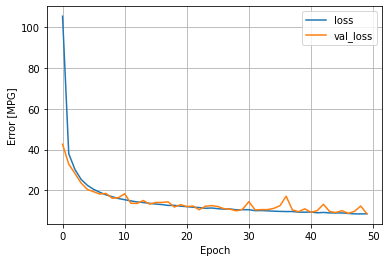

In [69]:
plot_loss(history)

In [70]:
# NN.save(os.path.join(SAVED_IN, MODEL_NAME))

In [71]:
# MODEL_NAME = "TBD"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [72]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [73]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,2.648019,2.694436
1,ip1k1,13.120750,14.496915


In [74]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

Average MSE of the prediction on training set:  7.884384287504756
Average MSE of the prediction on test set:  8.595675760394297


In [75]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = y[idx_test_sort] - y_test_
err_in_100 = y[idx_in_100] - y_[idx_in_100]
err_out_100 = y[idx_out_100] - y_[idx_out_100]
err_in_10 = y[idx_in_10] - y_[idx_in_10]
err_out_10 = y[idx_out_10] - y_[idx_out_10]
err_p100 = y[idx_p100] - y_[idx_p100]
err_n100 = y[idx_n100] - y_[idx_n100]
err_p10 = y[idx_p10] - y_[idx_p10]
err_n10 = y[idx_n10] - y_[idx_n10]

In [76]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,2.694436,1.641093
1,within 100,3.420025,1.847413
2,outside 100,1.783213,1.335118
3,within 10,3.854374,1.959588
4,outside 10,2.636104,1.623310
5,>100,1.426765,1.107257
6,<-100,2.140770,1.374543
7,>10,2.316771,1.486074
8,<-10,2.982007,1.702029


In [77]:
# Evaluation of intermediate seal pressure predictions on end stroke in test set
OUTPUT = 1 # ip1k1

err_dict_es_ip1k1 = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of ip1k1 predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of ip1k1 predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_ip1k1 = pd.DataFrame.from_dict(err_dict_es_ip1k1)
df_es_ip1k1.style.set_caption("Evaluation of intermediate-seal-pressure predictions on end stroke in test set")

,Positions,MSE of ip1k1 predictions,std of ip1k1 predictions
0,all test set,14.496915,3.774798
1,within 100,15.542280,3.933926
2,outside 100,13.184104,3.541963
3,within 10,14.615446,3.806768
4,outside 10,14.490954,3.773034
5,>100,9.571546,3.027040
6,<-100,16.807899,3.985870
7,>10,12.059765,3.440655
8,<-10,17.124430,4.102475


Predictions of Position


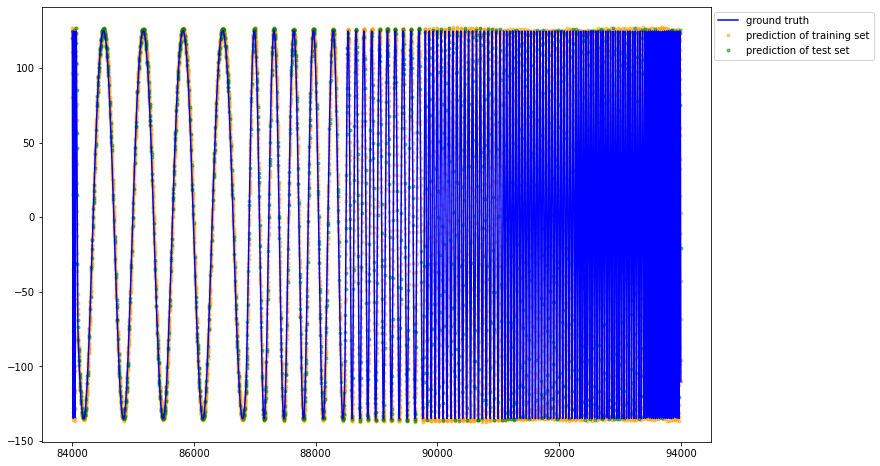

In [78]:
F = 84000
L = F+10000
print("Predictions of Position")
plot_one_gt_train_test(y[:,0],y_[:,0],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


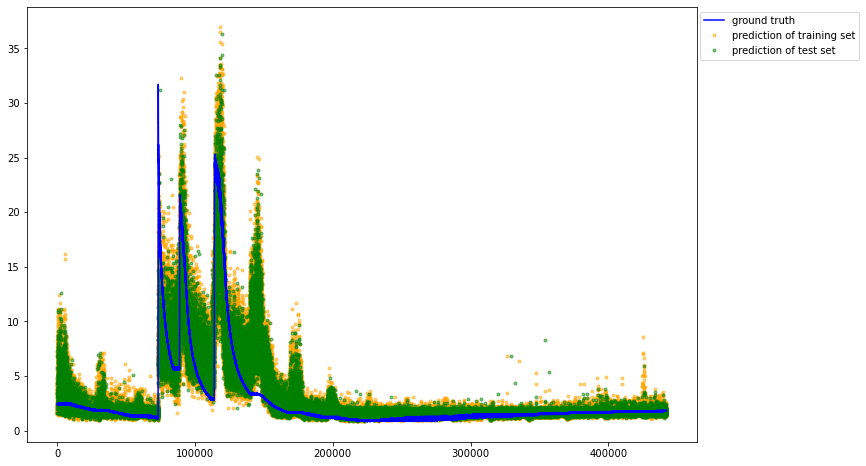

In [79]:
F = 0
L = len_p30
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


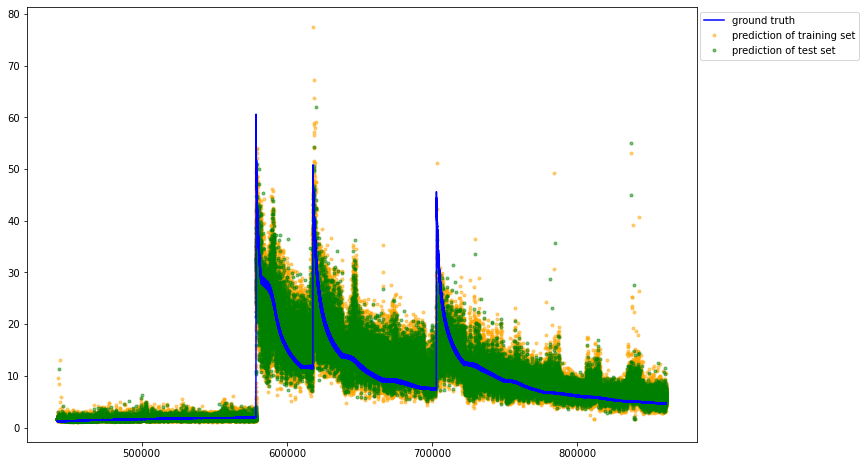

In [80]:
F = L
L = F + len_p100
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


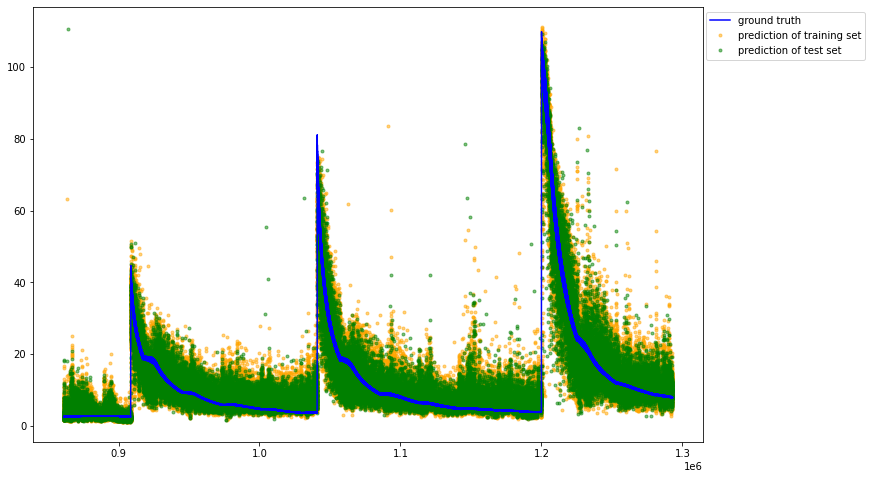

In [81]:
F = L
L = F + len_p200
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

## NN Training with 80-20 Split

### 80-20 Train test split

In [79]:
idx_train_sort = np.hstack(
                        [np.arange(len_p30//5*4),
                         np.arange(len_p30,len_p30+len_p100//5*4),
                         np.arange(len_p30+len_p100,len_p30+len_p100+len_p200//5*4)]
)
idx_test_sort = np.sort((list(set(np.arange(len_p100 + len_p30 + len_p200))-set(idx_train_sort))))

X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = y[idx_train_sort]
y_test = y[idx_test_sort]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034380, 242)
(1034380, 2)
(258597, 242)
(258597, 2)


In [80]:
# # for all dataset, the first 80% data are for training and the rest 20% are for test

# len_all = (len_p100 + len_p30 + len_p200)
# len_train = len_all//5*4

# idx_train_sort = np.arange(len_train)
# idx_test_sort = np.arange(len_train,len_all)

# X_train = X[idx_train_sort]
# X_test = X[idx_test_sort]
# y_train = y[idx_train_sort]
# y_test = y[idx_test_sort]

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

### 4-hidden-layer NN Model

In [98]:
MODEL_NAME = "TBD"

In [99]:
# TODO
def NN_nc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(2,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [100]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_nc(normalizer)
NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 34        
Total params: 42,487
Trainable params: 42,002
Non-trainable params: 485
________________________________________________

In [101]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    validation_split = 0.125,
    verbose=0, epochs=50, shuffle=True)

Wall time: 6min 29s


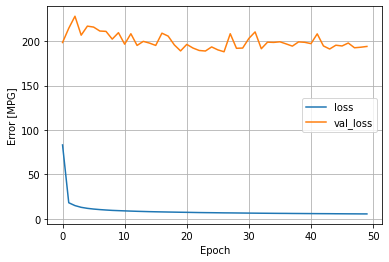

In [102]:
plot_loss(history)

In [103]:
# NN.save(os.path.join(SAVED_IN, MODEL_NAME))

In [104]:
# MODEL_NAME = "TBD"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [105]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [106]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,6.535331,80.639741
1,ip1k1,51.188104,145.680672


In [107]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

Average MSE of the prediction on training set:  28.861717833035208
Average MSE of the prediction on test set:  113.16020641873837


In [108]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = y[idx_test_sort] - y_test_
err_in_100 = y[idx_in_100] - y_[idx_in_100]
err_out_100 = y[idx_out_100] - y_[idx_out_100]
err_in_10 = y[idx_in_10] - y_[idx_in_10]
err_out_10 = y[idx_out_10] - y_[idx_out_10]
err_p100 = y[idx_p100] - y_[idx_p100]
err_n100 = y[idx_n100] - y_[idx_n100]
err_p10 = y[idx_p10] - y_[idx_p10]
err_n10 = y[idx_n10] - y_[idx_n10]

In [109]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,80.639741,8.957024
1,within 100,89.437997,9.453195
2,outside 100,69.511368,8.263641
3,within 10,44.003559,6.615274
4,outside 10,82.513277,9.060460
5,>100,100.023367,8.597414
6,<-100,38.632136,5.473257
7,>10,89.840873,8.567475
8,<-10,74.551006,8.077177


In [110]:
# Evaluation of intermediate seal pressure predictions on end stroke in test set
OUTPUT = 1 # ip1k1

err_dict_es_ip1k1 = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of ip1k1 predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of ip1k1 predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_ip1k1 = pd.DataFrame.from_dict(err_dict_es_ip1k1)
df_es_ip1k1.style.set_caption("Evaluation of intermediate-seal-pressure predictions on end stroke in test set")

,Positions,MSE of ip1k1 predictions,std of ip1k1 predictions
0,all test set,145.680672,11.995940
1,within 100,135.195310,11.569889
2,outside 100,158.942962,12.510402
3,within 10,118.469071,10.353429
4,outside 10,147.072245,12.064806
5,>100,195.601712,13.975081
6,<-100,121.843000,10.731293
7,>10,146.870955,12.055288
8,<-10,147.290968,12.075127


Predictions of Position


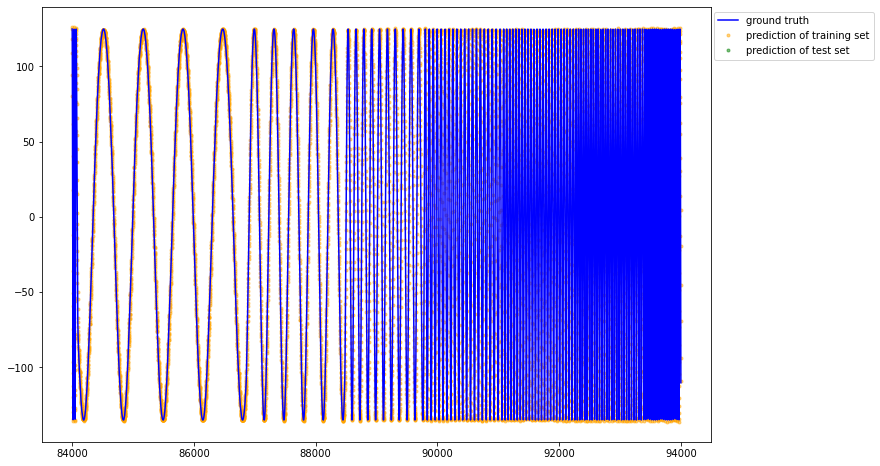

In [111]:
F = 84000
L = F+10000
print("Predictions of Position")
plot_one_gt_train_test(y[:,0],y_[:,0],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


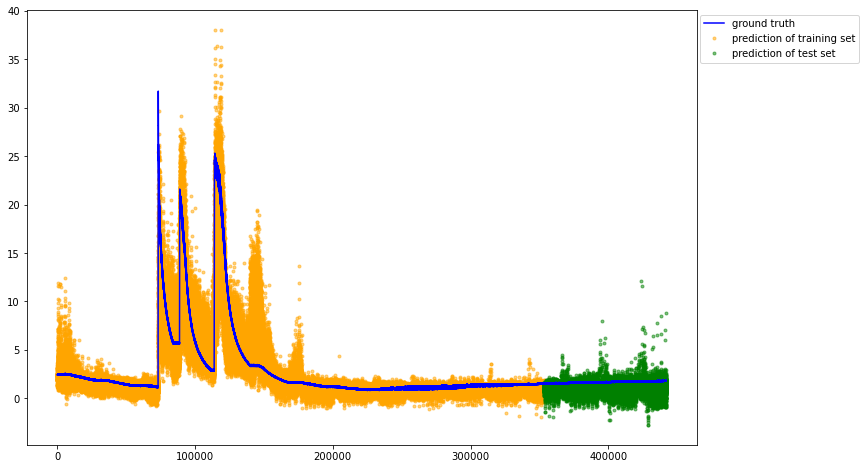

In [112]:
F = 0
L = len_p30
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


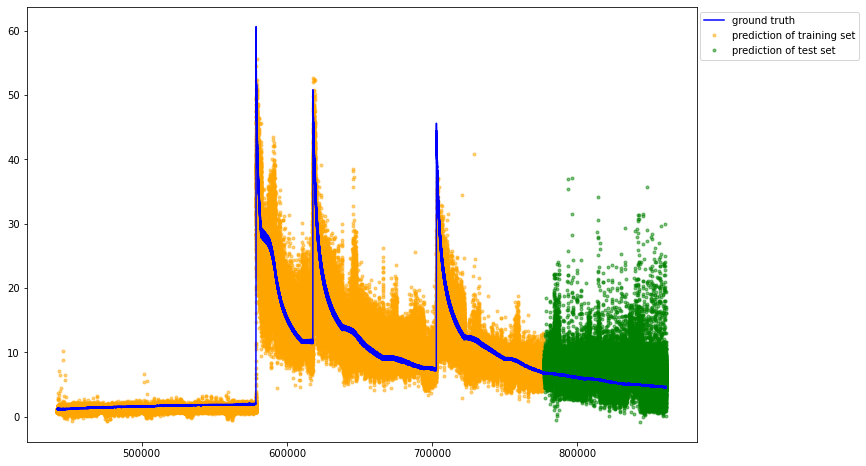

In [113]:
F = L
L = F + len_p100
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


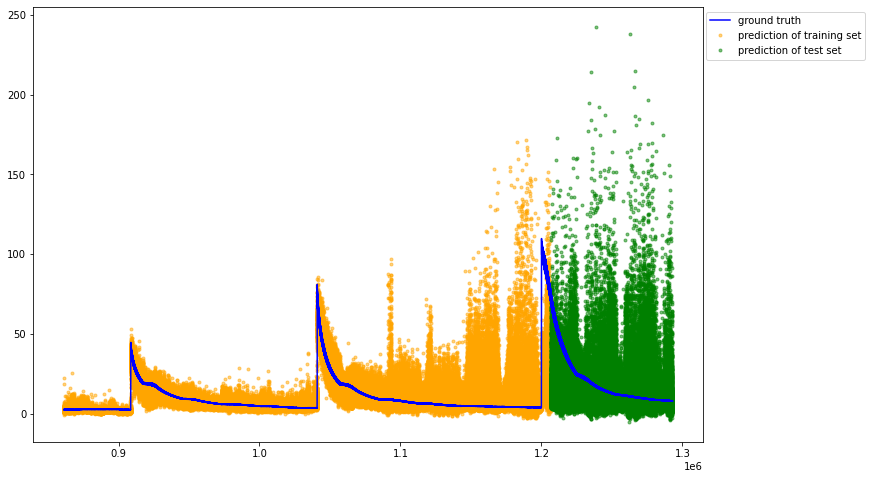

In [114]:
F = L
L = F + len_p200
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

## NN Training with Split considering temperatur

###  Split considering temperatur

According to the test plan, 3 datasets in V27 are all evenly divided into 8 segments by 8 different temperature levels.
(range(20,90,10). The rule is not perfectly followed in real world, see figures at the beginning of this notebook.)

In order to eliminate the influence of temperature, we use 80-20 split for each segement.


In [146]:
f = np.array([i*len_p30//8 for i in range(8)])
l =f + len_p30//8//5*4
idx_p30 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p100//8 for i in range(8)])+len_p30
l =f + len_p100//8//5*4
idx_p100 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

f = np.array([i*len_p200//8 for i in range(8)])+len_p30+len_p100
l =f + len_p200//8//5*4
idx_p200 = np.hstack([np.arange(f[i],l[i]) for i in range (8)])

idx_train_sort = np.hstack([idx_p30,idx_p100,idx_p200])
idx_test_sort = np.sort((list(set(np.arange(len_p100 + len_p30 + len_p200))-set(idx_train_sort))))

X_train = X[idx_train_sort]
X_test = X[idx_test_sort]
y_train = y[idx_train_sort]
y_test = y[idx_test_sort]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034336, 242)
(1034336, 2)
(258641, 242)
(258641, 2)


### 4-hidden-layer NN Model

In [147]:
MODEL_NAME = "TBD"

In [148]:
# TODO
def NN_nc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(16, kernel_initializer='normal',activation='relu'),
      layers.Dense(2,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [149]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_nc(normalizer)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_15 (Dense)             (None, 128)               31104     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 34        
Total params: 42,487
Trainable params: 42,002
Non-trainable params: 485
________________________________________________

In [150]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    validation_split = 0.125,
    verbose=0, epochs=50, shuffle=True)

Wall time: 8min


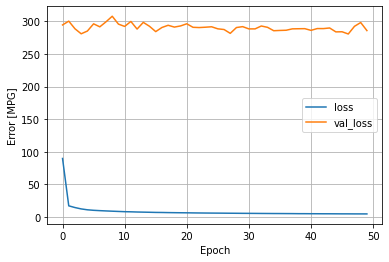

In [151]:
plot_loss(history)

In [152]:
# NN.save(os.path.join(SAVED_IN, MODEL_NAME))

In [153]:
# MODEL_NAME = "TBD"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [154]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [155]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,7.905328,7.971214
1,ip1k1,71.522621,23.716051


In [156]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

Average MSE of the prediction on training set:  39.713974075201385
Average MSE of the prediction on test set:  15.843632703996224


In [157]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = y[idx_test_sort] - y_test_
err_in_100 = y[idx_in_100] - y_[idx_in_100]
err_out_100 = y[idx_out_100] - y_[idx_out_100]
err_in_10 = y[idx_in_10] - y_[idx_in_10]
err_out_10 = y[idx_out_10] - y_[idx_out_10]
err_p100 = y[idx_p100] - y_[idx_p100]
err_n100 = y[idx_n100] - y_[idx_n100]
err_p10 = y[idx_p10] - y_[idx_p10]
err_n10 = y[idx_n10] - y_[idx_n10]

In [158]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,7.971214,2.812910
1,within 100,9.083867,2.970353
2,outside 100,6.560587,2.559494
3,within 10,8.974358,2.982281
4,outside 10,7.920052,2.803982
5,>100,7.352850,2.701067
6,<-100,5.753189,2.398141
7,>10,6.846489,2.608478
8,<-10,9.092628,3.002554


In [159]:
# Evaluation of intermediate seal pressure predictions on end stroke in test set
OUTPUT = 1 # ip1k1

err_dict_es_ip1k1 = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of ip1k1 predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of ip1k1 predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_ip1k1 = pd.DataFrame.from_dict(err_dict_es_ip1k1)
df_es_ip1k1.style.set_caption("Evaluation of intermediate-seal-pressure predictions on end stroke in test set")

,Positions,MSE of ip1k1 predictions,std of ip1k1 predictions
0,all test set,23.716051,4.851157
1,within 100,26.644553,5.141837
2,outside 100,20.003279,4.455216
3,within 10,23.599628,4.857899
4,outside 10,23.721989,4.849902
5,>100,18.404195,4.289535
6,<-100,21.632909,4.593780
7,>10,22.134400,4.683365
8,<-10,25.455999,5.025497


Predictions of Position


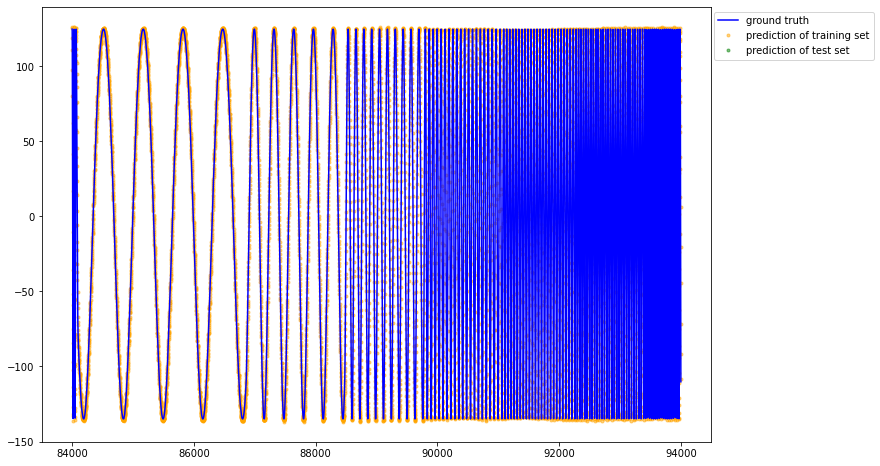

In [160]:
F = 84000
L = F+10000
print("Predictions of Position")
plot_one_gt_train_test(y[:,0],y_[:,0],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


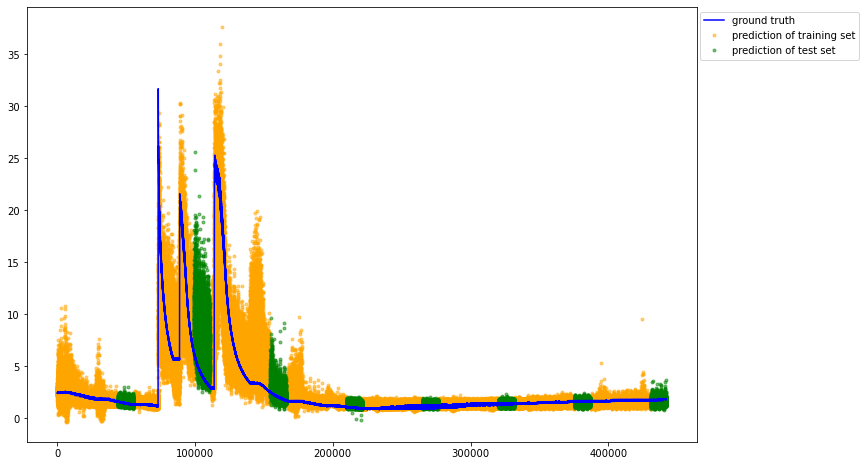

In [161]:
F = 0
L = len_p30
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


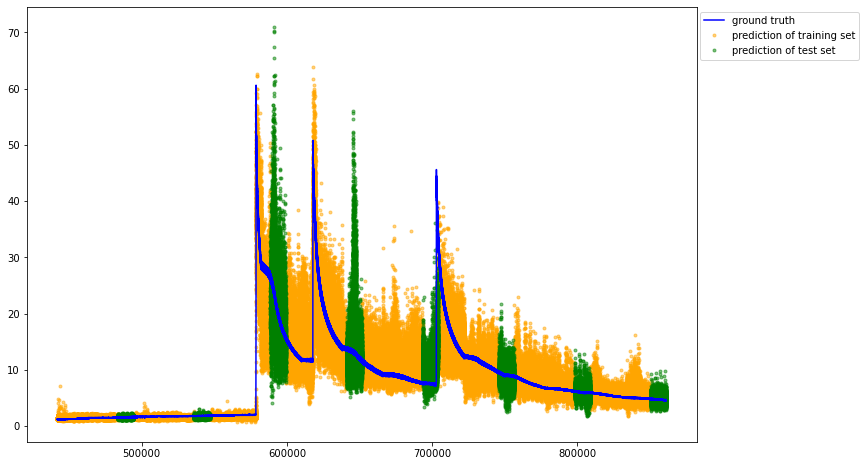

In [162]:
F = L
L = F + len_p100
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


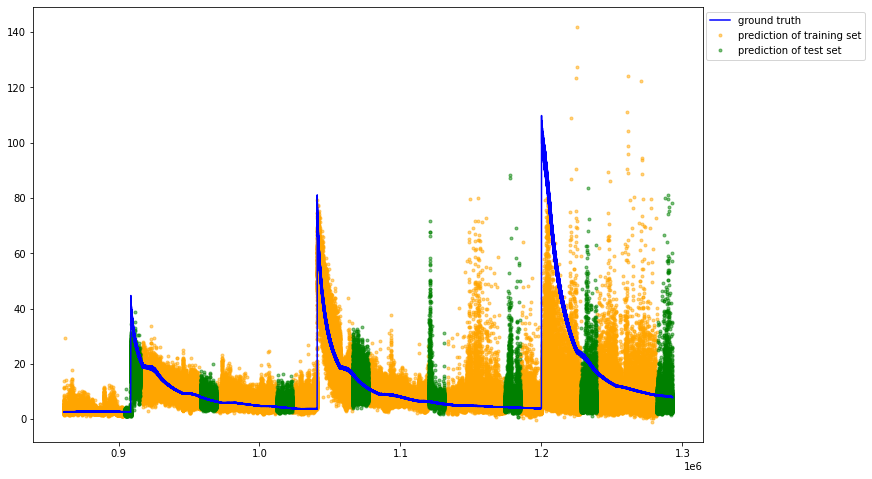

In [163]:
F = L
L = F + len_p200
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)